# Different stops detection methods

In order to analyze traces collected by citizens using GNSS, one of the first need is to detect stops. 
The goal of this section is to presents methods existing in tracklib library to detect stops in a GPS track.

1. findStopsLocal(track, speed=1, duration=10)

   This algorithm take maximal speed during stop and minimal stop duration (in seconds) into account


2. findStopsLocalWithAcceleration(track, diameter=20, duration=60)

   This algorithm detect stop point, knowing that a point is a stop when speed is null or very low and acceleration is negative.


3. findStopsGlobal(track, diameter=20, duration=60)

   This algorithm find stop points in a track based on two parameters: the maximal size of a stop (as the diameter of enclosing circle, in ground units) and minimal time duration (in seconds).


4. stdbscan(track, af_name, eps1, eps2, minPts, deltaAF)


<br/>

Ces algorithmes fonctionnent, mis à part les paramètres en entrée, de la même manière. Les entrées-sorties sont représentés dans la figure suivante:

<figure style='text-align:center'>
<img src="stop_structure.png"  width="650" />
<figcaption><br/>Figure 1: Input-output of stop detection algorithms</figcaption>
</figure>

Les résultats de la détection des pauses sont enregistrés dans une nouvelle trace qui contient un point par pause détectée. Ce point a une multitude d'AF qui fournit des métadonnées sur la pause comme: le nombre de point, l'index du premier point jusqu'à l'index du dernier (??? est-ce qu'il peut y avoir des points hors pause entre ?), la durée de la pause, le rmse, les moyennes des écarts, éventuellement le rayon spatial de recherche.


## Import de la librairie tracklib

In [1]:
# -*- coding: utf-8 -*-
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tracklib as trk

Import des modules nécessaires

In [2]:
import matplotlib.pyplot as plt


## Présentation de la trace

Présentons tout d'abord la trace sur laquelle les algos de détection des points d'arrêt s'appliqueront. Voir le quickstart aussi qui utilise cette trace.

C'est une trace d'un entrainement de course à pied autour d'une piste. Grosso modo, le coureur faisait des pauses sur place d'une durée d'environ 30 secondes

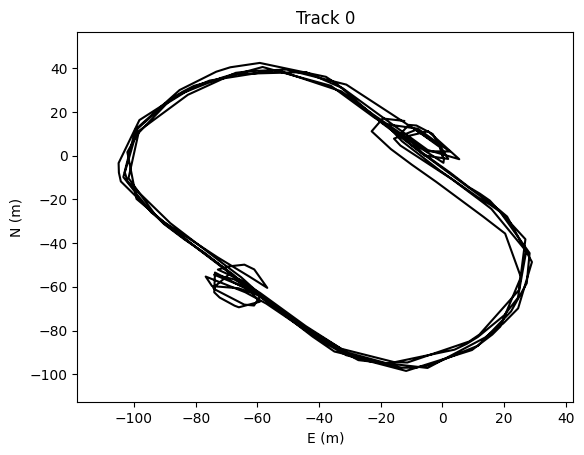

In [3]:
trk.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = trk.TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

trace.plot()
plt.show()

## st-dbscan

<div class="alert alert-block alert-info">
<b>Reference:</b> <br/>
Birant, D., & Kut, A. (2007). ST-DBSCAN: An algorithm for clustering
spatial–temporal data. Data & Knowledge Engineering, 60(1), 208-221.
</div>

DBSCAN algorithm with three important directions:
1. First, unlike the existing density-based clustering algorithms, our algorithm can cluster spatial–temporal data according to its non-spatial, spatial and temporal attributes. 
2. Second, DBSCAN cannot detect some noise points when clusters of diﬀerent densities exist. Our algorithm solves this problem by assigning to each cluster a density factor.
3. Third, the values of border objects in a cluster may be very diﬀerent than the values of border objects in opposite side, if the non-spatial values of neighbor objects have little diﬀerences and the clusters are adjacent to each other. Our algorithm solves this problem by comparing the average value of a cluster with new coming value.


In [4]:
# Quels paramètres choisir ?
# af_name : t for timestamp
# eps1 = to measure the closeness of two points geographically
# eps2 = to measure the similarity of timestamp values i.e. the proximity timestamp
# MinPts = minimum number of points (a threshold) clustered together
# deltaAF = to prevent the discovering of combined clusters

trk.stdbscan(trace, 't', 15, 30, 5, 1)

print ('New analytical features: ', trace.getListAnalyticalFeatures())

New analytical features:  ['stdbscan', 'noise']


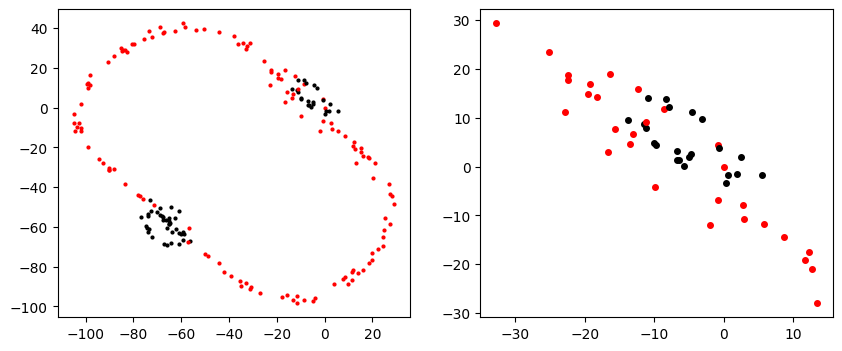

In [5]:
# visualisation des noises
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
for i in range(len(trace)):
    o = trace[i]
    if trace.getObsAnalyticalFeature('noise', i) > 0:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ro', markersize=2)
    else:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=2)


# Dans la zone des pauses
ll = trk.ENUCoords(-40, -40)
ur = trk.ENUCoords(15, 30)
bbox = trk.Rectangle(ll, ur)
ax2 = fig.add_subplot(122)
for i in range(len(trace)):
    o = trace[i]
    if trace.getObsAnalyticalFeature('noise', i) > 0 and bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ro', markersize=4)
    elif bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=4)
plt.show()

## Analyse des clusters pour la méthode st-dbscan

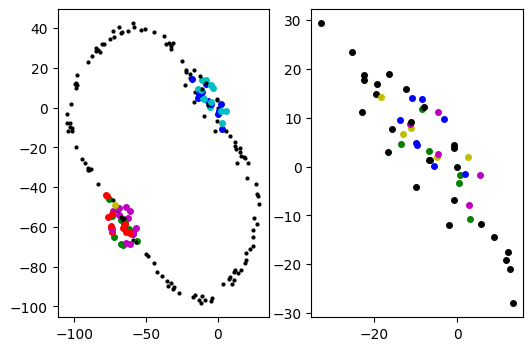

In [6]:
fig = plt.figure(figsize=(6, 4))
COLORS = ['ro','go','bo','yo','mo','co']

ax1 = fig.add_subplot(121)
for i in range(len(trace)):
    o = trace[i]
    cluster = trace.getObsAnalyticalFeature('stdbscan', i)
    if cluster > 0:
        #print (cluster)
        color = COLORS[cluster%6]
        ax1.plot([o.position.getX()], [o.position.getY()], color, markersize=4)
    else:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=2)

ax2 = fig.add_subplot(122)
cpt = 0
clusterOld = -1
d=dict()
for i in range(len(trace)):
    o = trace[i]
    cluster = trace.getObsAnalyticalFeature('stdbscan', i)
    if cluster > 0 and bbox.contains(o.position):
        if cluster != clusterOld:
            cpt += 1
            d[COLORS[cpt%6]] = []
        color = COLORS[cpt%6]
        ax2.plot([o.position.getX()], [o.position.getY()], color, markersize=4)
        d[color].append(i)
        #ax2.text(o.position.getX()+0.1, o.position.getY()+0.1, str(i))
        clusterOld = cluster
    elif bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=4)
plt.show()

In [7]:
print ('Détail des clusters dans la figure de droite:')
for k in d:
    print (k, d[k])

Détail des clusters dans la figure de droite:
go [29, 30, 32, 34, 35, 36]
bo [67, 68, 69, 70, 71, 72, 73, 74]
yo [109, 110, 112, 113, 114]
mo [147, 149, 150, 151, 152]
